In [1]:
import torch
from torch.utils.data import Dataset
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import h5py

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
if not os.path.exists("traindata.pkl"):
    !wget -O traindata.pkl https://tu-dortmund.sciebo.de/s/kpCMGPutwk6vKOP/download

In [8]:
train_data1 = pd.read_pickle("data/train_data_[50627, 50631].pkl")
train_data2 = pd.read_pickle("data/train_data_[49473, 49477, 49487, 49489].pkl")
train_data3 = pd.read_pickle("data/train_data_20231108.pkl")

train_data = pd.concat([train_data1, train_data2, train_data3], ignore_index=True)

In [9]:
train_df, val_df = train_test_split(train_data, test_size = 0.2)

train_X, train_Y = train_df['train_X'], train_df['train_Y']
val_X, val_Y = val_df['train_X'], val_df['train_Y']

Train set size : 10674 	 Validation set size : 2669
(64, 271) (64, 271)


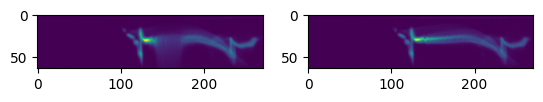

In [16]:
print(f"Train set size : {train_X.shape[-1]} \t Validation set size : {val_X.shape[-1]}")
idx = 6000
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_X[idx])
ax[1].imshow(train_Y[idx])

print(train_X[idx].shape, train_Y[idx].shape)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 30
LR = 1e-4
IMAGE_SIZE_X, IMAGE_SIZE_Y = 140, 200
BATCH_SIZE = 32

In [18]:
import albumentations as alb

def get_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y)
      ], is_check_shapes=False)

def get_val_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y),
      ], is_check_shapes=False)

In [19]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # The original dataset was created wrong so it requires image = train_Y
        image = row.train_X    
        mask = row.train_Y


        if self.augmentations:
            data = self.augmentations(image = image) #, mask = mask)
            image = data['image']
            data = self.augmentations(image = mask)
            mask = data['image']

        image = np.expand_dims(image,axis=0)
        mask = np.expand_dims(mask,axis=0)

        return image, mask

In [20]:
trainset = SegmentationDataset(train_df, get_augs())
valset = SegmentationDataset(val_df, get_augs())

print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(valset)}")

Size of Trainset : 10674
Size of Validset : 2669


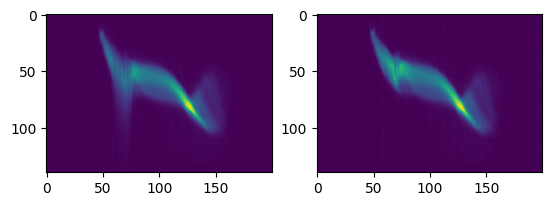

In [21]:
idx = 500
image, mask = trainset[idx]
fig, ax = plt.subplots(1,2)
ax[0].imshow(image[0])
ax[1].imshow(mask[0])

In [22]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = False)
valloader = DataLoader(valset, batch_size= BATCH_SIZE)

## Definition of the U-Net and the training functions

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv0 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv10 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv11 = nn.Conv2d(32, 1, 1)
        

    def forward(self, x):
        # Encoder
        x0 = F.relu(self.conv0(x))
        
        x1 = F.relu(self.conv1(x0))
        x1 = F.relu(self.conv2(x1))
        x2 = self.pool1(x1)
        
        x2 = F.relu(self.conv3(x2))
        x2 = F.relu(self.conv4(x2))
        x3 = self.pool2(x2)
        
        # Bottleneck
        x3 = F.relu(self.conv5(x3))
        x3 = F.relu(self.conv6(x3))
        
        # Decoder
        x4 = self.upconv1(x3)
        x4 = torch.cat([x4, x2], dim=1)
        x4 = F.relu(self.conv7(x4))
        x4 = F.relu(self.conv8(x4))
        
        x5 = self.upconv2(x4)
        x5 = torch.cat([x5, x1], dim=1)
        x5 = F.relu(self.conv9(x5))
        x5 = F.relu(self.conv10(x5))
        x5 = self.conv11(x5)
        return x5

# Instantiate the model
model = UNet()

# Print the model architecture
print(model)

UNet(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_

In [25]:
def train_function(data_loader, model, criterion, optimizer):

    model.train()
    total_loss = 0.0

    for inputs, targets in tqdm(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_function(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(data_loader)

100%|██████████| 84/84 [00:07<00:00, 11.73it/s]


Epoch: 1   Train loss: 0.0005701283808519804  Val_loss: 0.00010277525117479464


100%|██████████| 84/84 [00:07<00:00, 11.82it/s]


Epoch: 2   Train loss: 6.927421433616899e-05  Val_loss: 5.398122036803259e-05


100%|██████████| 84/84 [00:07<00:00, 11.80it/s]


Epoch: 3   Train loss: 3.9236187241655356e-05  Val_loss: 3.0004132614045548e-05


100%|██████████| 84/84 [00:07<00:00, 11.80it/s]


Epoch: 4   Train loss: 2.880745152303249e-05  Val_loss: 2.4136819471702136e-05


100%|██████████| 84/84 [00:07<00:00, 11.77it/s]


Epoch: 5   Train loss: 2.326923553656904e-05  Val_loss: 2.025835735929875e-05


100%|██████████| 84/84 [00:07<00:00, 11.80it/s]


Epoch: 6   Train loss: 2.0015614979625415e-05  Val_loss: 2.0769212391141557e-05


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 7   Train loss: 1.8327440549017377e-05  Val_loss: 1.8917671013696236e-05


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 8   Train loss: 1.686005289284258e-05  Val_loss: 1.768833253447069e-05


100%|██████████| 84/84 [00:07<00:00, 11.82it/s]


Epoch: 9   Train loss: 1.5534366607943287e-05  Val_loss: 1.5549227576966152e-05


100%|██████████| 84/84 [00:07<00:00, 11.79it/s]


Epoch: 10   Train loss: 1.4503775044780226e-05  Val_loss: 1.538740801671728e-05


100%|██████████| 84/84 [00:07<00:00, 11.82it/s]


Epoch: 11   Train loss: 1.4175068674681214e-05  Val_loss: 1.76722282958508e-05


100%|██████████| 84/84 [00:07<00:00, 11.83it/s]


Epoch: 12   Train loss: 1.3156224006211315e-05  Val_loss: 1.3814241334503527e-05


100%|██████████| 84/84 [00:07<00:00, 11.82it/s]


Epoch: 13   Train loss: 1.24680547665928e-05  Val_loss: 1.1766081851895987e-05


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 14   Train loss: 1.1524266181063168e-05  Val_loss: 1.1926535264484256e-05


100%|██████████| 84/84 [00:07<00:00, 11.80it/s]


Epoch: 15   Train loss: 1.2032103605051163e-05  Val_loss: 1.190943888624523e-05


100%|██████████| 84/84 [00:07<00:00, 11.77it/s]


Epoch: 16   Train loss: 1.1606412355210855e-05  Val_loss: 1.1429059538516282e-05


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 17   Train loss: 9.819083104870689e-06  Val_loss: 1.0277384652519167e-05


100%|██████████| 84/84 [00:07<00:00, 11.79it/s]


Epoch: 18   Train loss: 9.927128996401778e-06  Val_loss: 1.0657206449390547e-05


100%|██████████| 84/84 [00:07<00:00, 11.88it/s]


Epoch: 19   Train loss: 9.434774034150927e-06  Val_loss: 1.004563628590577e-05


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 20   Train loss: 9.191462218340658e-06  Val_loss: 1.0040880451491657e-05


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 21   Train loss: 9.7433730203563e-06  Val_loss: 1.0833546650160098e-05


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 22   Train loss: 8.927926815711892e-06  Val_loss: 9.905428539371184e-06


100%|██████████| 84/84 [00:07<00:00, 11.79it/s]


Epoch: 23   Train loss: 8.313956891878753e-06  Val_loss: 9.332319688751123e-06


100%|██████████| 84/84 [00:07<00:00, 11.80it/s]


Epoch: 24   Train loss: 8.028954348147326e-06  Val_loss: 1.0221251424506287e-05


100%|██████████| 84/84 [00:07<00:00, 11.89it/s]


Epoch: 25   Train loss: 8.06522520380492e-06  Val_loss: 9.396800150863696e-06


100%|██████████| 84/84 [00:07<00:00, 11.81it/s]


Epoch: 26   Train loss: 9.249794056595856e-06  Val_loss: 1.0735317952518622e-05


100%|██████████| 84/84 [00:07<00:00, 11.82it/s]


Epoch: 27   Train loss: 8.491284187677408e-06  Val_loss: 9.66112410575685e-06


100%|██████████| 84/84 [00:07<00:00, 11.74it/s]


Epoch: 28   Train loss: 7.853381643264343e-06  Val_loss: 9.384170864125605e-06


100%|██████████| 84/84 [00:07<00:00, 11.77it/s]


Epoch: 29   Train loss: 6.940278668306185e-06  Val_loss: 8.970002909336472e-06


100%|██████████| 84/84 [00:07<00:00, 11.76it/s]

Epoch: 30   Train loss: 6.5965791786575594e-06  Val_loss: 7.486220364886062e-06


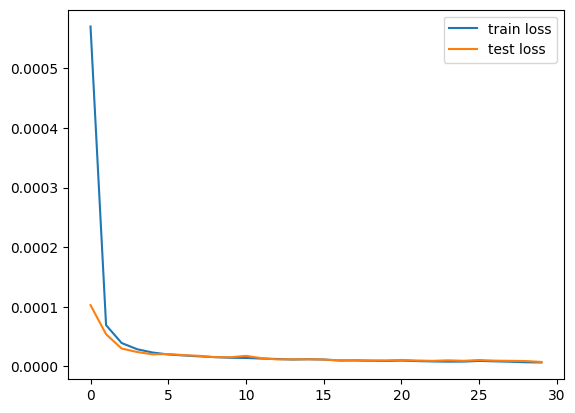

In [26]:
model = UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Training loop
EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = np.Inf

train_L, val_L = [], []
for i in range(EPOCHS):

    train_loss = train_function(trainloader, model, criterion, optimizer)
    train_L.append(train_loss)
    val_loss = eval_function(valloader, model)
    val_L.append(val_loss)

    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_val_loss = val_loss

    print(f"Epoch: {i+1}   Train loss: {train_loss}  Val_loss: {val_loss}")
    
plt.plot(train_L, label="train loss")
plt.plot(val_L, label="test loss")
plt.legend()

In [ ]:
val_inp = [inputs for inputs,outputs in valloader]
val_out = [outputs for inputs,outputs in valloader]
train_inp = [inputs for inputs,outputs in trainloader]
train_out = [outputs for inputs,outputs in trainloader]

In [30]:
len(val_inp)

84

Text(0.5, 1.0, 'original image')

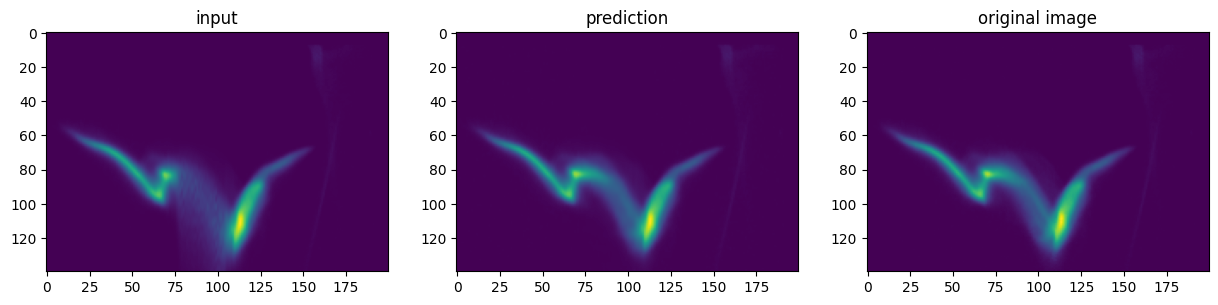

In [34]:
idx = 1
valX = val_inp[20][idx]
valX = valX.to(device)
valY = val_out[20][idx]

model.eval()
with torch.no_grad():
    val_pred = model(valX.unsqueeze(0))
    
valX = valX.squeeze().cpu()
valY = valY.squeeze().cpu()
val_pred = val_pred.squeeze().cpu()

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(valX)
ax[0].set_title("input")
ax[1].imshow(val_pred)
ax[1].set_title("prediction")
ax[2].imshow(valY)
ax[2].set_title("original image")

In [35]:
def model_pred(model, img, plot=False):
    #device = 'cuda'
    img = (img / np.max(img)).astype(np.float32)
    kernel_size = 5
    img = cv2.medianBlur(img, kernel_size)
    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(img, (N, M))
    data = get_augs()(image = img)
    img = data['image']
    
    img = np.expand_dims(img, axis=0)
    testX = torch.tensor(img).to(device)
    
    model.eval()
    with torch.no_grad():
        test_pred = model(testX.unsqueeze(0))

    testX = testX.squeeze().cpu()
    test_pred = test_pred.squeeze().cpu()
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(testX)
        ax[0].set_title("Input")
        ax[1].imshow(test_pred)
        ax[1].set_title("Model Prediction")
    
    return testX, test_pred


def plot_power_profile(pred_in, pred_out):
    
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T

    mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_diff = mean_px_sase_on - mean_px_sase_off

    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on**2 - std_px_sase_off**2
    
    plt.figure()
    plt.imshow(pred_in)
    plt.plot(mean_px_sase_on, alpha=0.5)
    plt.plot(mean_px_sase_off, alpha=0.5)
    plt.ylim(139,0)
    plt.plot(140 - mean_diff*5, label = "power profile from mean", alpha=0.8)
    plt.plot(140 - std_diff* 5**(2/3) * 0.15, label = "power profile from energy spread", alpha=0.7)
    plt.legend()

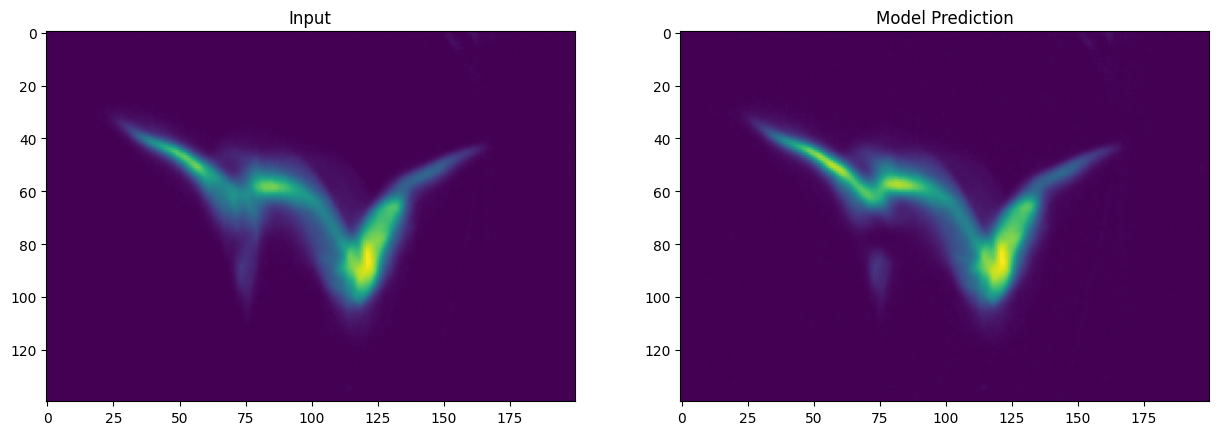

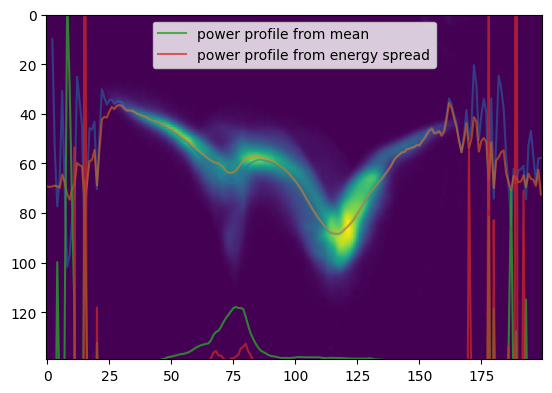

In [36]:
sase_on = np.load("data/lhpulses_two-sase_on-polarix-2023-11-08T031510.npy").astype(np.float32)
img = sase_on[8]
pred_in, pred_out = model_pred(model, img, plot=True)
plot_power_profile(pred_in, pred_out)

## To load a saved model

In [10]:
model = UNet()
state_dict = torch.load("best_model.pt")
model.load_state_dict(state_dict)
model.to(device)

UNet(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_

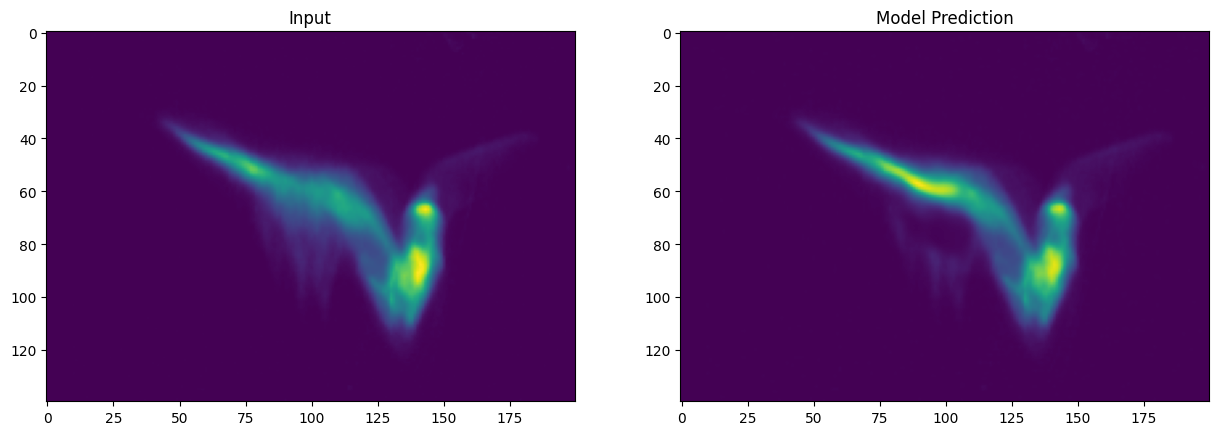

In [37]:
sase_on = np.load('data/lhpulses_zero-sase_on-polarix-2023-11-08T032511.npy').astype(np.float32)
img = sase_on[5]
pred_in, pred_out = model_pred(model, img, plot=True)

In [41]:
filepath = '/asap3/flash/gpfs/fl21/2023/data/11019168/raw/hdf/online-0/fl2user2/'
filestr = glob.glob(filepath+f'/*run{49478}*20231121*')[0]

In [43]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50630}*20240125*')[0]

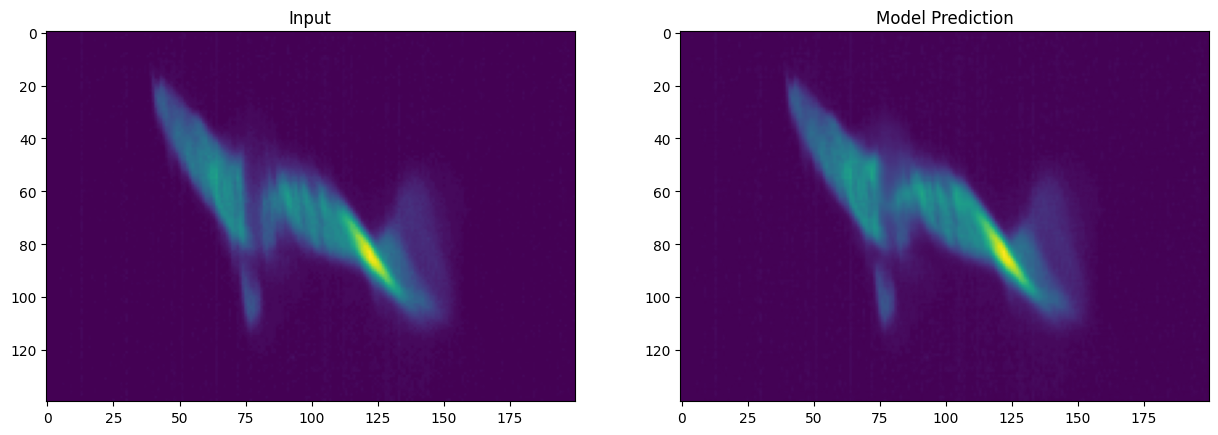

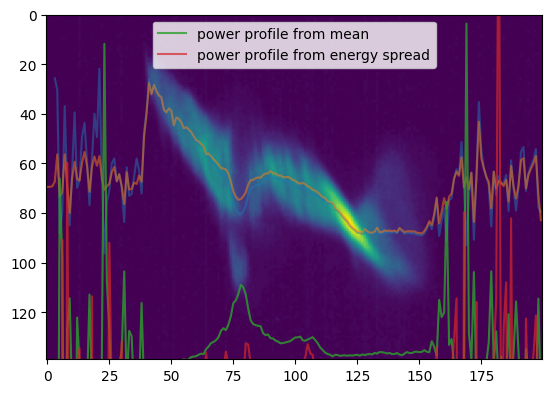

In [48]:
with h5py.File(filestr,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][50])

pred_in, pred_out = model_pred(model, imarr[:,:], plot=True)
plot_power_profile(pred_in, pred_out)

In [61]:
del model